In [2]:
# import necessary libraries 
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.special

# set custom plotting values
mpl.rcParams['figure.figsize'] = (20,8)
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20 
mpl.rcParams['ytick.labelsize'] = 20 
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['lines.markersize'] = 1000
mpl.rcParams['legend.fontsize'] = 18

# Kepler Equation

In this notebook, I explore the use of Pade approximants to improve the order-by-order convergence of series expansions of the Kepler equation:

$$E(t) = M(t) + e \sin E(t)$$ 

where $t$ is time, $E$ is the eccentric anomaly, $M$ is the mean anomaly, and $e$ is the orbital eccentricity. Because this is a transcendental equation, there doesn't exist a clean analytic solution. 

# Iteration - Newton Raphson

A common way to solve the Kepler equation is via iteration. That is, one looks for the root of the equation:

$$f(E) = E - e \sin E - M $$

via some root-finding method where the time dependence is now implicit. In this notebook, we use the popular and simple Newton-Raphson method and treat its output as a truth benchmark for comparing the accuracy of our series expansions. The Newton-Raphson update equation is given by,

$$E_{i+1} = E_i - \frac{f(E_i)}{f'(E_i)} = E_i - \frac{E_i - e \sin(E_i) - M}{1 - e \cos(E_i)} $$

The initial choice for eccentric anomaly to start the iteration, $E_0$, can be chosen to be as simple as $E_0 = M$. The empirically optimal $E_0$ is given by:

$$E_0= \begin{cases}
    M + e^2 [(6M)^{1/3} - M], & \text{if $0\le M<0.25$}.\\
    M + \frac{e \sin(M)}{1 - \sin(M+e) + \sin(M)}, & \text{if $ 0.25 \le M \le \pi$}.
  \end{cases}$$
  
Note that care must be taken when using the optimal $E_0$ for $e>0.95$ and $M<0.1$ due to vanishing denominators. 

In [3]:
from kepler_solutions import Newton_Raphson

e = 0.95
M = 0.5
accuracy_values = [1/10**x for x in range(0, 16)]
Newton_values = [Newton_Raphson(e, M, x) - Newton_Raphson(e, M, accuracy_values[-1]) for x in accuracy_values]

Here we visualize the results of the Newton-Raphson method by specifying an eccentricity, mean anomaly, and desired accuracy. Plotted below is the absolute difference between the $E_i$ and the $E_{i+1}$ term for a number of accuracy settings. As can be seen, the solution rapidly converges and improves by many order of magnitudes for a given iteration. For the given $e$ and $M$, an accuracy setting below about $10^{-4}$ approaches machine precision. 

Text(0,0.5,'$|\\ E_{i+1} - E_i \\ |$')

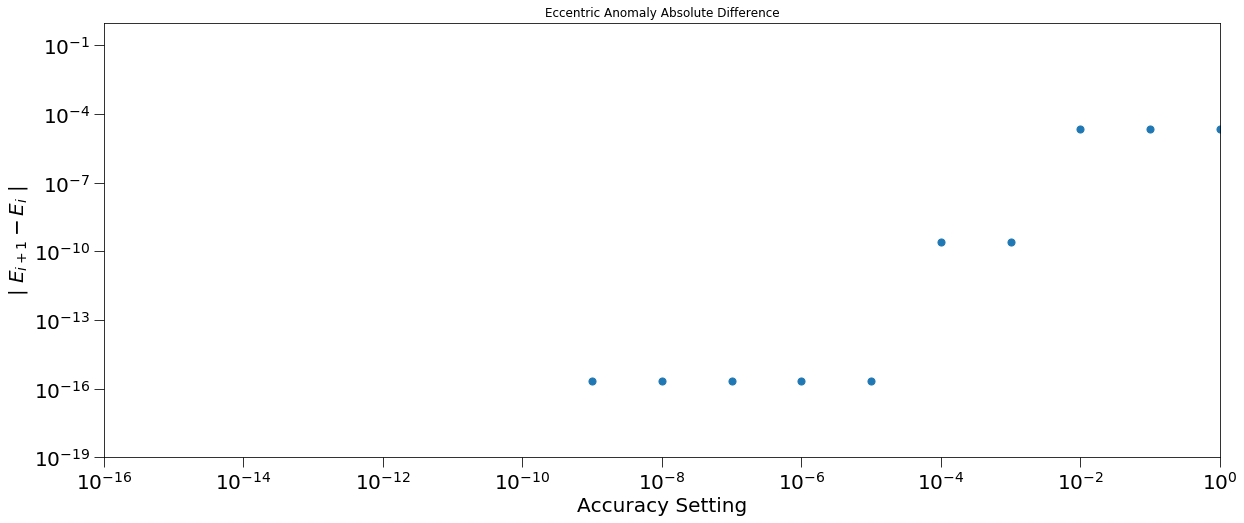

In [4]:
plt.scatter(accuracy_values, Newton_values, s = 50)
plt.xlim([1e-16, 1])
plt.ylim([1e-19, 1])
plt.xscale('log')
plt.yscale('log')
plt.title('Eccentric Anomaly Absolute Difference')
plt.xlabel('Accuracy Setting')
plt.ylabel('$|\ E_{i+1} - E_i \ |$')

# Eccentricity Expansion

An alternative way to solve the Kepler equation is to instead perform a series expansion. Several different ones exist but one of the simplest is an expansion in powers of the eccentricity $e$ as given by:

$$E = M + \sum_{n=1}^{\infty} a_n e^n$$

where the coefficients $a_n$ can be found using the Lagrange Inversion theorem,

$$a_n = \frac{1}{2^{n-1} n!} \sum_{k=0}^{\lfloor n / 2\rfloor} (-1)^k \binom{n}{k}(n - 2k)^{n-1} \sin[(n - 2k)M]$$ 

However this expansion has a limited radius of convergence and diverges above an eccentricity value of approximately 0.663, a number referred to as the Laplace limit. To keep the analysis simple, we choose a specific value for $M$ and examine the series convergence as a function of the eccentricity. 

In [5]:
from kepler_solutions import taylor_coeff_func_eccentricity

ecc_values = [x / 100 for x in range(1, 100)]
M = 0.25
laplace_limit = 0.663

taylor_ecc_fix_M = lambda e : taylor_coeff_func_eccentricity(e, 0.25)

In [6]:
from pade_approximants import get_array_taylor_coeff, get_polynomial, pade_approximant

expand_1 = []
expand_3 = []
expand_5 = []
expand_7 = []
expand_9 = []
expand_11 = []
expand_13 = []
expand_31 = []

pade_1 = []
pade_2 = []
pade_3 = []
pade_4 = []
pade_5 = []
pade_6 = []
pade_15 = []

taylor_coeffs = get_array_taylor_coeff(32, taylor_ecc_fix_M)

for ecc in ecc_values:
    truth = Newton_Raphson(ecc, M, 1e-15)
    expand_1.append(abs(truth - get_polynomial(taylor_coeffs, ecc, 1)))
    expand_3.append(abs(truth - get_polynomial(taylor_coeffs, ecc, 3)))
    expand_5.append(abs(truth - get_polynomial(taylor_coeffs, ecc, 5)))
    expand_7.append(abs(truth - get_polynomial(taylor_coeffs, ecc, 7)))
    expand_9.append(abs(truth - get_polynomial(taylor_coeffs, ecc, 9)))
    expand_11.append(abs(truth - get_polynomial(taylor_coeffs, ecc, 11)))
    expand_13.append(abs(truth - get_polynomial(taylor_coeffs, ecc, 13)))
    expand_31.append(abs(truth - get_polynomial(taylor_coeffs, ecc, 31)))

    pade_1.append(abs(truth - pade_approximant(ecc, 2, taylor_ecc_fix_M)))
    pade_2.append(abs(truth - pade_approximant(ecc, 4, taylor_ecc_fix_M)))
    pade_3.append(abs(truth - pade_approximant(ecc, 6, taylor_ecc_fix_M)))
    pade_4.append(abs(truth - pade_approximant(ecc, 8, taylor_ecc_fix_M)))
    pade_5.append(abs(truth - pade_approximant(ecc, 10, taylor_ecc_fix_M)))
    pade_6.append(abs(truth - pade_approximant(ecc, 12, taylor_ecc_fix_M)))    
    pade_15.append(abs(truth - pade_approximant(ecc, 30, taylor_ecc_fix_M))) 

Below, we plot the absolute difference between the Newton-Raphson and the output from the eccentricity expansion at a given order. As can be seen, adding an increasing number of terms to the Taylor series rapidly improves the accuracy of the expansion at lower eccentricities. In all of the truncated expansions, we see the usual power law behavior of series expansions with the solution degrading as the eccentricity approaches 1. The formal limit of applicability of the expansion given by the Laplace limit is marked by the dashed black line. 

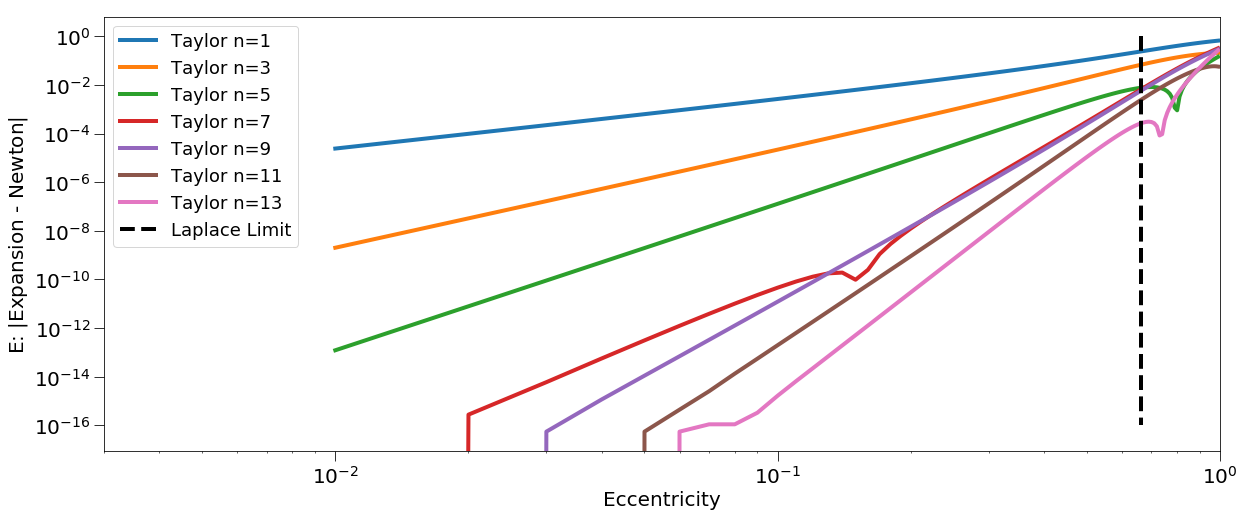

In [7]:
plt.plot(ecc_values, expand_1, label= 'Taylor n=1')
plt.plot(ecc_values, expand_3, label= 'Taylor n=3')
plt.plot(ecc_values, expand_5, label= 'Taylor n=5')
plt.plot(ecc_values, expand_7, label= 'Taylor n=7')
plt.plot(ecc_values, expand_9, label= 'Taylor n=9')
plt.plot(ecc_values, expand_11, label= 'Taylor n=11')
plt.plot(ecc_values, expand_13, label= 'Taylor n=13')

plt.plot([laplace_limit, laplace_limit], [1, 1e-16], 'k--', label='Laplace Limit')
plt.xlabel('Eccentricity')
plt.ylabel('E: $|$Expansion - Newton$|$')
plt.xlim([3e-3, 1])
plt.yscale('log')
plt.xscale('log')
plt.legend()

# Pade Approximants

Now we look at the Pade approximants formed from the Taylor expansion coeffcients. At present we only look at the diagonal Pade approximants where the polynomials in the ratio are of the same order. For the [n,n] Pade approximant, Taylor expansion coeffcients up to $a_{2n+1}$ are used in its construction. 

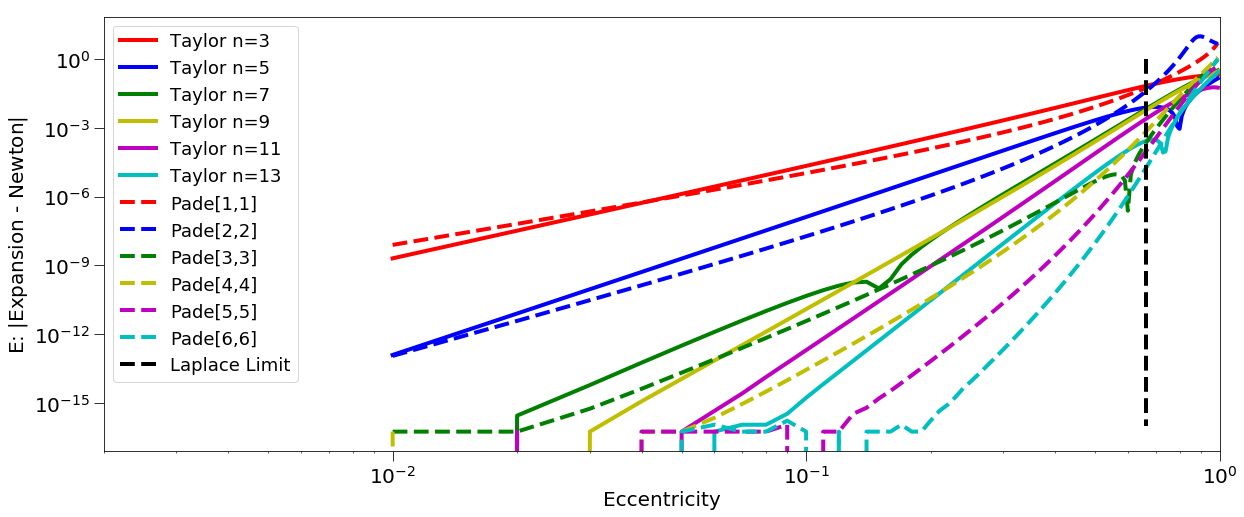

In [8]:
plt.plot(ecc_values, expand_3, 'r', label= 'Taylor n=3')
plt.plot(ecc_values, expand_5, 'b', label= 'Taylor n=5')
plt.plot(ecc_values, expand_7, 'g', label= 'Taylor n=7')
plt.plot(ecc_values, expand_9, 'y', label= 'Taylor n=9')
plt.plot(ecc_values, expand_11, 'm', label= 'Taylor n=11')
plt.plot(ecc_values, expand_13, 'c', label= 'Taylor n=13')
plt.plot(ecc_values, pade_1, 'r--', label = 'Pade[1,1]')
plt.plot(ecc_values, pade_2, 'b--', label = 'Pade[2,2]')
plt.plot(ecc_values, pade_3, 'g--', label = 'Pade[3,3]')
plt.plot(ecc_values, pade_4, 'y--', label = 'Pade[4,4]')
plt.plot(ecc_values, pade_5, 'm--', label = 'Pade[5,5]')
plt.plot(ecc_values, pade_6, 'c--', label = 'Pade[6,6]')

plt.plot([laplace_limit, laplace_limit], [1, 1e-16], 'k--', label='Laplace Limit')
plt.xlabel('Eccentricity')
plt.ylabel('E: $|$Expansion - Newton$|$')
plt.xlim([2e-3, 1])
plt.yscale('log')
plt.xscale('log')
plt.legend()

Here we plot the absolute difference of expansions versus the eccentricity. The diagonal Pade approximant and the order equivalent Taylor series are plotted here in the same color: Taylor series as a solid line, Pade approximant as a dotted line. By equivalent Pade approximant, we mean that the Pade approximant contains information from Taylor series up to the same order. The Laplace Limit is again give as as the solid vertical black line. 

As can be seen, at low orders, the behavor of both series track one another quite closesly (red, blue, green) with some improvement at higher orders.

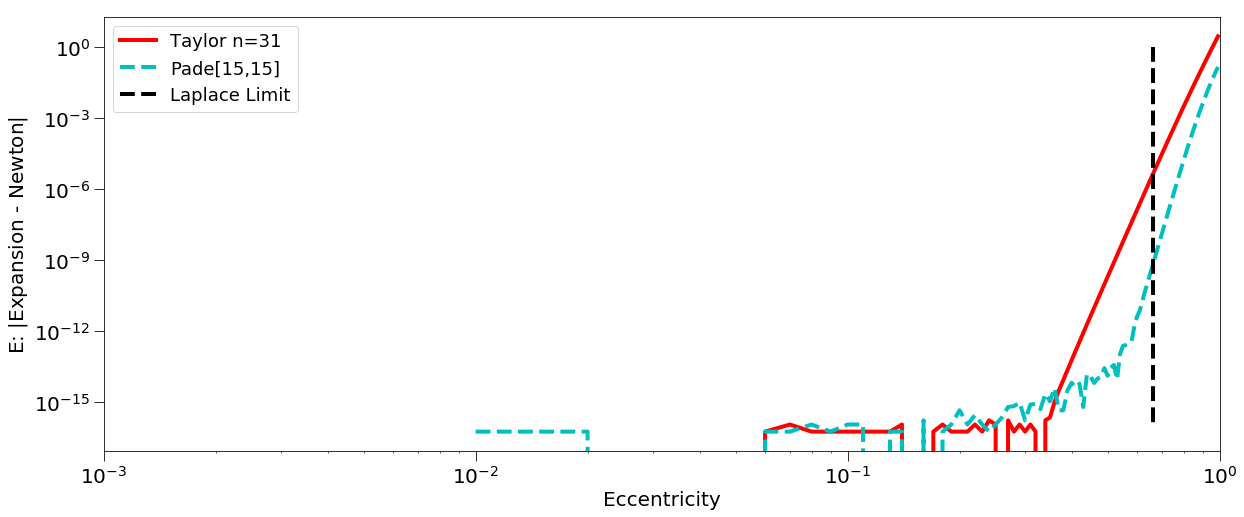

In [9]:
plt.plot(ecc_values, expand_31, 'r', label= 'Taylor n=31')
plt.plot(ecc_values, pade_15, 'c--', label = 'Pade[15,15]')

plt.plot([laplace_limit, laplace_limit], [1, 1e-16], 'k--', label='Laplace Limit')
plt.xlabel('Eccentricity')
plt.ylabel('E: $|$Expansion - Newton$|$')
plt.xlim([1e-3, 1])
plt.yscale('log')
plt.xscale('log')
plt.legend()

Even at heroic expansion orders, the Pade approximant is only mildly more accurate at larger eccentricities. It also does not remedy the convergence problem as $e \rightarrow 1$.